In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Any Reason for this?
])

data=ImageFolder("./archive/Dataset/", transform=data_transform)

In [3]:
BATCH_SIZE = 128
CHANNELS = 3
RAND_DIM = 100
IMG_DIM = 128
NGPU = 1

device = torch.device("cuda:0")

dataloader=DataLoader(data,batch_size=BATCH_SIZE,drop_last=False,shuffle=True)

In [4]:
import torch.nn.functional as F

class DNet(torch.nn.Module): # Discriminator Net (Same as training net)
    def __init__(self):
        super(DNet, self).__init__()
        # Set for convolution operation
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(CHANNELS, 16, 3, padding=1), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*8*8, 32),
            torch.nn.ReLU()
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        # Three-layer convolutional network (Conv -> ReLU -> MaxPool)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x) # Fully connected layer -> ReLU
        x = self.fc2(x)
        return x

dnet_gpu = DNet().to(device)


In [5]:
class GNet(torch.nn.Module): # Generator Net
    def __init__(self):
        super(GNet, self).__init__()
        # Set for convolution operation
        self.conv0 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(RAND_DIM, IMG_DIM * 16, kernel_size=4, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(IMG_DIM * 16), 
            torch.nn.ReLU(), 
        )
        self.conv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(IMG_DIM * 16, IMG_DIM * 8, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(IMG_DIM * 8), 
            torch.nn.ReLU(), 
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(IMG_DIM * 8, IMG_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(IMG_DIM * 4),
            torch.nn.ReLU(),
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(IMG_DIM * 4, IMG_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(IMG_DIM * 2),
            torch.nn.ReLU(),
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(IMG_DIM * 2, IMG_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(IMG_DIM),
            torch.nn.ReLU(),
        )
        self.conv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(IMG_DIM, CHANNELS, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh(),
        )
        
    def forward(self, x):
        # Three-layer convolutional network (Conv -> ReLU -> MaxPool)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

gnet_gpu = GNet().to(device)
#   128*128*3

In [6]:
from torch import optim

optimizer_d = optim.Adam(
    dnet_gpu.parameters(),
    lr = 0.001,
    betas = (0.9, 0.999),
    eps = 1e-08,
    weight_decay = 0,
    amsgrad = False
)

optimizer_g = optim.Adam(
    gnet_gpu.parameters(),
    lr = 0.001,
    betas = (0.9, 0.999),
    eps = 1e-08,
    weight_decay = 0,
    amsgrad = False
)

loss_func = torch.nn.BCELoss()

fixed_noise = torch.randn(64, RAND_DIM, 1, 1, device=device)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

Train Epoch: 0 [1920/5000] D-Loss: 0.620631 G-Loss: 3.752686
Train Epoch: 0 [3968/5000] D-Loss: 0.323365 G-Loss: 2.897259
Train Epoch: 0 [6016/5000] D-Loss: 0.029723 G-Loss: 8.137974


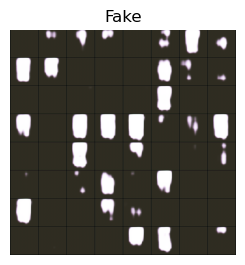

Train Epoch: 1 [1920/5000] D-Loss: 0.028731 G-Loss: 7.280564
Train Epoch: 1 [3968/5000] D-Loss: 0.036729 G-Loss: 11.439844
Train Epoch: 1 [6016/5000] D-Loss: 0.625033 G-Loss: 9.541747
Train Epoch: 2 [1920/5000] D-Loss: 0.605415 G-Loss: 3.386896
Train Epoch: 2 [3968/5000] D-Loss: 1.470398 G-Loss: 2.019850
Train Epoch: 2 [6016/5000] D-Loss: 1.160665 G-Loss: 1.605094
Train Epoch: 3 [1920/5000] D-Loss: 0.799886 G-Loss: 1.758806
Train Epoch: 3 [3968/5000] D-Loss: 0.698381 G-Loss: 2.404707
Train Epoch: 3 [6016/5000] D-Loss: 0.351882 G-Loss: 2.371909
Train Epoch: 4 [1920/5000] D-Loss: 0.500038 G-Loss: 3.949688
Train Epoch: 4 [3968/5000] D-Loss: 1.846416 G-Loss: 0.099139
Train Epoch: 4 [6016/5000] D-Loss: 0.495032 G-Loss: 5.128822
Train Epoch: 5 [1920/5000] D-Loss: 0.251757 G-Loss: 3.386813
Train Epoch: 5 [3968/5000] D-Loss: 0.297179 G-Loss: 4.978414
Train Epoch: 5 [6016/5000] D-Loss: 1.813661 G-Loss: 4.517722


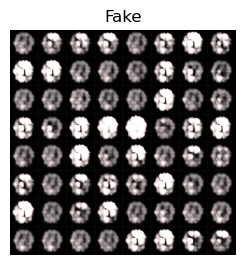

Train Epoch: 6 [1920/5000] D-Loss: 0.697197 G-Loss: 2.558181
Train Epoch: 6 [3968/5000] D-Loss: 2.148966 G-Loss: 1.067138
Train Epoch: 6 [6016/5000] D-Loss: 0.826043 G-Loss: 2.669941
Train Epoch: 7 [1920/5000] D-Loss: 0.344904 G-Loss: 2.617375
Train Epoch: 7 [3968/5000] D-Loss: 0.737916 G-Loss: 2.819423
Train Epoch: 7 [6016/5000] D-Loss: 2.308386 G-Loss: 1.269044
Train Epoch: 8 [1920/5000] D-Loss: 0.286483 G-Loss: 2.478392
Train Epoch: 8 [3968/5000] D-Loss: 0.815064 G-Loss: 1.466595
Train Epoch: 8 [6016/5000] D-Loss: 0.786132 G-Loss: 1.878022
Train Epoch: 9 [1920/5000] D-Loss: 0.594064 G-Loss: 3.091740
Train Epoch: 9 [3968/5000] D-Loss: 0.632960 G-Loss: 1.804797
Train Epoch: 9 [6016/5000] D-Loss: 0.678797 G-Loss: 2.408049
Train Epoch: 10 [1920/5000] D-Loss: 0.520791 G-Loss: 2.356299
Train Epoch: 10 [3968/5000] D-Loss: 0.504598 G-Loss: 1.949342
Train Epoch: 10 [6016/5000] D-Loss: 0.952953 G-Loss: 2.442424


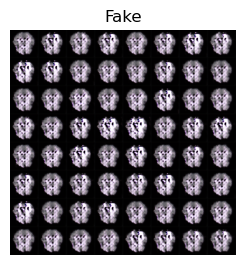

Train Epoch: 11 [1920/5000] D-Loss: 0.747288 G-Loss: 1.321373
Train Epoch: 11 [3968/5000] D-Loss: 0.217975 G-Loss: 3.468381
Train Epoch: 11 [6016/5000] D-Loss: 1.121833 G-Loss: 3.947107
Train Epoch: 12 [1920/5000] D-Loss: 0.301901 G-Loss: 4.665808
Train Epoch: 12 [3968/5000] D-Loss: 0.790332 G-Loss: 2.797332
Train Epoch: 12 [6016/5000] D-Loss: 0.777384 G-Loss: 1.147980
Train Epoch: 13 [1920/5000] D-Loss: 0.426973 G-Loss: 3.162313
Train Epoch: 13 [3968/5000] D-Loss: 2.018709 G-Loss: 2.006040
Train Epoch: 13 [6016/5000] D-Loss: 1.706564 G-Loss: 1.183115
Train Epoch: 14 [1920/5000] D-Loss: 0.976977 G-Loss: 1.544701
Train Epoch: 14 [3968/5000] D-Loss: 0.183519 G-Loss: 2.503435
Train Epoch: 14 [6016/5000] D-Loss: 0.234319 G-Loss: 3.637300
Train Epoch: 15 [1920/5000] D-Loss: 2.160779 G-Loss: 2.263383
Train Epoch: 15 [3968/5000] D-Loss: 0.613857 G-Loss: 2.966665
Train Epoch: 15 [6016/5000] D-Loss: 0.116188 G-Loss: 3.391873


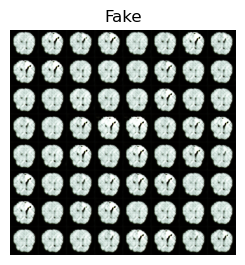

Train Epoch: 16 [1920/5000] D-Loss: 1.226496 G-Loss: 1.939894
Train Epoch: 16 [3968/5000] D-Loss: 0.511762 G-Loss: 2.786935
Train Epoch: 16 [6016/5000] D-Loss: 0.512526 G-Loss: 3.337615
Train Epoch: 17 [1920/5000] D-Loss: 0.237639 G-Loss: 4.138672
Train Epoch: 17 [3968/5000] D-Loss: 1.572751 G-Loss: 2.334280
Train Epoch: 17 [6016/5000] D-Loss: 0.083890 G-Loss: 3.295315
Train Epoch: 18 [1920/5000] D-Loss: 0.073469 G-Loss: 3.084571
Train Epoch: 18 [3968/5000] D-Loss: 1.073678 G-Loss: 2.440577
Train Epoch: 18 [6016/5000] D-Loss: 0.224322 G-Loss: 3.437482
Train Epoch: 19 [1920/5000] D-Loss: 0.426915 G-Loss: 3.981864
Train Epoch: 19 [3968/5000] D-Loss: 0.346252 G-Loss: 2.870422
Train Epoch: 19 [6016/5000] D-Loss: 0.415284 G-Loss: 3.943544
Train Epoch: 20 [1920/5000] D-Loss: 0.339909 G-Loss: 3.632792
Train Epoch: 20 [3968/5000] D-Loss: 0.761192 G-Loss: 4.201749
Train Epoch: 20 [6016/5000] D-Loss: 1.170472 G-Loss: 3.148186


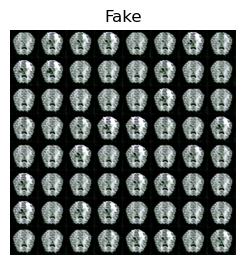

Train Epoch: 21 [1920/5000] D-Loss: 0.471630 G-Loss: 5.876425
Train Epoch: 21 [3968/5000] D-Loss: 0.410605 G-Loss: 4.369297
Train Epoch: 21 [6016/5000] D-Loss: 0.644118 G-Loss: 2.656657
Train Epoch: 22 [1920/5000] D-Loss: 0.226817 G-Loss: 4.529696
Train Epoch: 22 [3968/5000] D-Loss: 0.362913 G-Loss: 3.613520
Train Epoch: 22 [6016/5000] D-Loss: 0.908346 G-Loss: 4.751914
Train Epoch: 23 [1920/5000] D-Loss: 0.278952 G-Loss: 6.420827
Train Epoch: 23 [3968/5000] D-Loss: 0.467144 G-Loss: 4.078788
Train Epoch: 23 [6016/5000] D-Loss: 0.311568 G-Loss: 0.368239
Train Epoch: 24 [1920/5000] D-Loss: 0.812857 G-Loss: 5.152391
Train Epoch: 24 [3968/5000] D-Loss: 0.065257 G-Loss: 6.432172
Train Epoch: 24 [6016/5000] D-Loss: 0.179623 G-Loss: 5.239373
Train Epoch: 25 [1920/5000] D-Loss: 0.709756 G-Loss: 1.933937
Train Epoch: 25 [3968/5000] D-Loss: 0.474705 G-Loss: 3.050380
Train Epoch: 25 [6016/5000] D-Loss: 0.399784 G-Loss: 3.023294


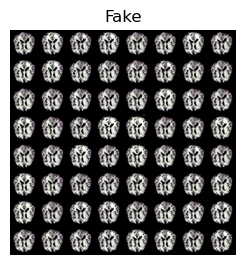

Train Epoch: 26 [1920/5000] D-Loss: 0.324032 G-Loss: 3.872917
Train Epoch: 26 [3968/5000] D-Loss: 0.239058 G-Loss: 2.194970
Train Epoch: 26 [6016/5000] D-Loss: 0.526818 G-Loss: 1.905610
Train Epoch: 27 [1920/5000] D-Loss: 0.563949 G-Loss: 6.254292
Train Epoch: 27 [3968/5000] D-Loss: 0.669935 G-Loss: 2.771668
Train Epoch: 27 [6016/5000] D-Loss: 0.448923 G-Loss: 5.000283
Train Epoch: 28 [1920/5000] D-Loss: 0.080021 G-Loss: 6.041643
Train Epoch: 28 [3968/5000] D-Loss: 0.627078 G-Loss: 4.388107
Train Epoch: 28 [6016/5000] D-Loss: 0.429771 G-Loss: 4.632345
Train Epoch: 29 [1920/5000] D-Loss: 0.569584 G-Loss: 2.282325
Train Epoch: 29 [3968/5000] D-Loss: 0.655299 G-Loss: 2.039386
Train Epoch: 29 [6016/5000] D-Loss: 0.373528 G-Loss: 3.650390
Train Epoch: 30 [1920/5000] D-Loss: 0.893325 G-Loss: 5.131932
Train Epoch: 30 [3968/5000] D-Loss: 0.418272 G-Loss: 5.854839
Train Epoch: 30 [6016/5000] D-Loss: 0.163301 G-Loss: 1.771946


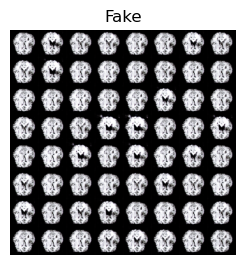

Train Epoch: 31 [1920/5000] D-Loss: 0.671122 G-Loss: 4.044340
Train Epoch: 31 [3968/5000] D-Loss: 0.328745 G-Loss: 2.411425
Train Epoch: 31 [6016/5000] D-Loss: 1.031084 G-Loss: 7.007136
Train Epoch: 32 [1920/5000] D-Loss: 0.535564 G-Loss: 2.910047
Train Epoch: 32 [3968/5000] D-Loss: 0.453885 G-Loss: 2.659522
Train Epoch: 32 [6016/5000] D-Loss: 0.470690 G-Loss: 2.651394
Train Epoch: 33 [1920/5000] D-Loss: 0.190090 G-Loss: 3.872406
Train Epoch: 33 [3968/5000] D-Loss: 0.379193 G-Loss: 3.997615
Train Epoch: 33 [6016/5000] D-Loss: 0.463718 G-Loss: 4.301066
Train Epoch: 34 [1920/5000] D-Loss: 0.269728 G-Loss: 3.047270
Train Epoch: 34 [3968/5000] D-Loss: 0.358603 G-Loss: 2.665477
Train Epoch: 34 [6016/5000] D-Loss: 0.493482 G-Loss: 3.197266
Train Epoch: 35 [1920/5000] D-Loss: 1.535028 G-Loss: 8.424935
Train Epoch: 35 [3968/5000] D-Loss: 1.652283 G-Loss: 6.296321
Train Epoch: 35 [6016/5000] D-Loss: 0.397874 G-Loss: 2.168586


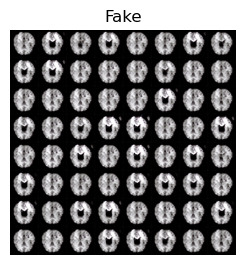

Train Epoch: 36 [1920/5000] D-Loss: 0.091191 G-Loss: 5.349733
Train Epoch: 36 [3968/5000] D-Loss: 0.526846 G-Loss: 3.767495
Train Epoch: 36 [6016/5000] D-Loss: 0.414172 G-Loss: 3.140286
Train Epoch: 37 [1920/5000] D-Loss: 0.455696 G-Loss: 3.021224
Train Epoch: 37 [3968/5000] D-Loss: 0.407753 G-Loss: 3.078928
Train Epoch: 37 [6016/5000] D-Loss: 0.477401 G-Loss: 3.090838
Train Epoch: 38 [1920/5000] D-Loss: 0.591929 G-Loss: 2.232069
Train Epoch: 38 [3968/5000] D-Loss: 0.420592 G-Loss: 2.907135
Train Epoch: 38 [6016/5000] D-Loss: 0.497808 G-Loss: 3.974330
Train Epoch: 39 [1920/5000] D-Loss: 0.195395 G-Loss: 3.277156
Train Epoch: 39 [3968/5000] D-Loss: 0.535334 G-Loss: 4.609308
Train Epoch: 39 [6016/5000] D-Loss: 0.793924 G-Loss: 6.156008
Train Epoch: 40 [1920/5000] D-Loss: 0.253465 G-Loss: 5.681975
Train Epoch: 40 [3968/5000] D-Loss: 0.372263 G-Loss: 3.653792
Train Epoch: 40 [6016/5000] D-Loss: 0.206606 G-Loss: 3.528642


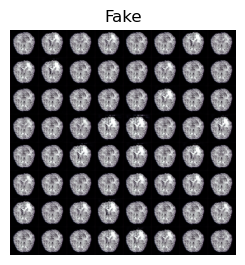

Train Epoch: 41 [1920/5000] D-Loss: 0.422421 G-Loss: 3.069598
Train Epoch: 41 [3968/5000] D-Loss: 0.393572 G-Loss: 3.686675
Train Epoch: 41 [6016/5000] D-Loss: 0.620056 G-Loss: 3.437696
Train Epoch: 42 [1920/5000] D-Loss: 0.400316 G-Loss: 3.903860
Train Epoch: 42 [3968/5000] D-Loss: 0.320969 G-Loss: 5.309864
Train Epoch: 42 [6016/5000] D-Loss: 0.857732 G-Loss: 4.088079
Train Epoch: 43 [1920/5000] D-Loss: 0.454659 G-Loss: 2.122256
Train Epoch: 43 [3968/5000] D-Loss: 0.553265 G-Loss: 3.349783
Train Epoch: 43 [6016/5000] D-Loss: 1.112058 G-Loss: 1.925044
Train Epoch: 44 [1920/5000] D-Loss: 0.562896 G-Loss: 2.611276
Train Epoch: 44 [3968/5000] D-Loss: 0.333349 G-Loss: 3.661124
Train Epoch: 44 [6016/5000] D-Loss: 0.346085 G-Loss: 5.472315
Train Epoch: 45 [1920/5000] D-Loss: 0.310228 G-Loss: 3.882528
Train Epoch: 45 [3968/5000] D-Loss: 0.463913 G-Loss: 3.167953
Train Epoch: 45 [6016/5000] D-Loss: 0.222674 G-Loss: 4.035709


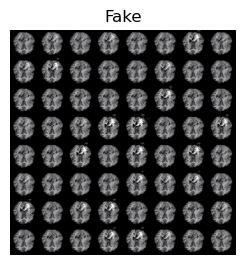

Train Epoch: 46 [1920/5000] D-Loss: 1.105503 G-Loss: 0.628190
Train Epoch: 46 [3968/5000] D-Loss: 0.897577 G-Loss: 5.384284
Train Epoch: 46 [6016/5000] D-Loss: 1.143742 G-Loss: 3.261919
Train Epoch: 47 [1920/5000] D-Loss: 0.244393 G-Loss: 3.333646
Train Epoch: 47 [3968/5000] D-Loss: 0.360163 G-Loss: 2.991303
Train Epoch: 47 [6016/5000] D-Loss: 0.467425 G-Loss: 3.157298
Train Epoch: 48 [1920/5000] D-Loss: 0.554853 G-Loss: 3.152487
Train Epoch: 48 [3968/5000] D-Loss: 0.511649 G-Loss: 3.615672
Train Epoch: 48 [6016/5000] D-Loss: 0.350106 G-Loss: 4.072041
Train Epoch: 49 [1920/5000] D-Loss: 0.547387 G-Loss: 4.647380
Train Epoch: 49 [3968/5000] D-Loss: 0.409953 G-Loss: 4.687531
Train Epoch: 49 [6016/5000] D-Loss: 0.375135 G-Loss: 7.027030
Train Epoch: 50 [1920/5000] D-Loss: 0.828060 G-Loss: 3.288312
Train Epoch: 50 [3968/5000] D-Loss: 0.579508 G-Loss: 3.301752
Train Epoch: 50 [6016/5000] D-Loss: 0.137874 G-Loss: 3.658839


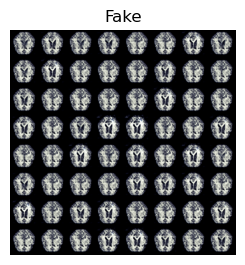

Train Epoch: 51 [1920/5000] D-Loss: 0.433462 G-Loss: 3.734538
Train Epoch: 51 [3968/5000] D-Loss: 0.338235 G-Loss: 3.501250
Train Epoch: 51 [6016/5000] D-Loss: 0.183905 G-Loss: 7.584962
Train Epoch: 52 [1920/5000] D-Loss: 1.312748 G-Loss: 3.879839
Train Epoch: 52 [3968/5000] D-Loss: 0.282865 G-Loss: 2.203984
Train Epoch: 52 [6016/5000] D-Loss: 0.455327 G-Loss: 2.740016
Train Epoch: 53 [1920/5000] D-Loss: 0.274456 G-Loss: 4.119394
Train Epoch: 53 [3968/5000] D-Loss: 0.426200 G-Loss: 3.742188
Train Epoch: 53 [6016/5000] D-Loss: 0.492660 G-Loss: 2.289934
Train Epoch: 54 [1920/5000] D-Loss: 0.683404 G-Loss: 4.316451
Train Epoch: 54 [3968/5000] D-Loss: 0.444979 G-Loss: 2.287118
Train Epoch: 54 [6016/5000] D-Loss: 0.461759 G-Loss: 3.623129
Train Epoch: 55 [1920/5000] D-Loss: 0.428947 G-Loss: 5.296576
Train Epoch: 55 [3968/5000] D-Loss: 0.592178 G-Loss: 3.621313
Train Epoch: 55 [6016/5000] D-Loss: 0.715334 G-Loss: 2.838659


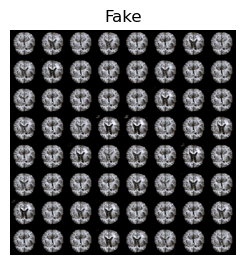

Train Epoch: 56 [1920/5000] D-Loss: 0.602180 G-Loss: 2.922879
Train Epoch: 56 [3968/5000] D-Loss: 0.748578 G-Loss: 2.055559
Train Epoch: 56 [6016/5000] D-Loss: 0.682449 G-Loss: 3.620935
Train Epoch: 57 [1920/5000] D-Loss: 0.123806 G-Loss: 4.566719
Train Epoch: 57 [3968/5000] D-Loss: 0.735957 G-Loss: 1.936661
Train Epoch: 57 [6016/5000] D-Loss: 0.262648 G-Loss: 6.794894
Train Epoch: 58 [1920/5000] D-Loss: 0.328910 G-Loss: 3.692234
Train Epoch: 58 [3968/5000] D-Loss: 0.602013 G-Loss: 4.049365
Train Epoch: 58 [6016/5000] D-Loss: 0.697813 G-Loss: 4.068985
Train Epoch: 59 [1920/5000] D-Loss: 0.218673 G-Loss: 4.970861
Train Epoch: 59 [3968/5000] D-Loss: 0.208075 G-Loss: 4.716311
Train Epoch: 59 [6016/5000] D-Loss: 0.121100 G-Loss: 6.131151
Train Epoch: 60 [1920/5000] D-Loss: 0.178941 G-Loss: 4.564821
Train Epoch: 60 [3968/5000] D-Loss: 2.051748 G-Loss: 4.503987
Train Epoch: 60 [6016/5000] D-Loss: 0.229077 G-Loss: 3.034917


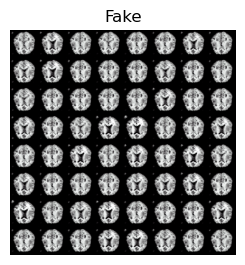

Train Epoch: 61 [1920/5000] D-Loss: 0.294386 G-Loss: 4.903909
Train Epoch: 61 [3968/5000] D-Loss: 0.506195 G-Loss: 3.793943
Train Epoch: 61 [6016/5000] D-Loss: 0.360867 G-Loss: 3.407473
Train Epoch: 62 [1920/5000] D-Loss: 0.470193 G-Loss: 3.406794
Train Epoch: 62 [3968/5000] D-Loss: 0.218482 G-Loss: 4.071246
Train Epoch: 62 [6016/5000] D-Loss: 0.415637 G-Loss: 4.034445
Train Epoch: 63 [1920/5000] D-Loss: 1.349407 G-Loss: 11.452553
Train Epoch: 63 [3968/5000] D-Loss: 0.498367 G-Loss: 1.958487
Train Epoch: 63 [6016/5000] D-Loss: 0.451440 G-Loss: 4.889888
Train Epoch: 64 [1920/5000] D-Loss: 0.635080 G-Loss: 3.049534
Train Epoch: 64 [3968/5000] D-Loss: 0.517202 G-Loss: 3.979232
Train Epoch: 64 [6016/5000] D-Loss: 0.668467 G-Loss: 3.128254
Train Epoch: 65 [1920/5000] D-Loss: 0.258526 G-Loss: 5.562471
Train Epoch: 65 [3968/5000] D-Loss: 0.258311 G-Loss: 5.226520
Train Epoch: 65 [6016/5000] D-Loss: 0.833445 G-Loss: 2.271490


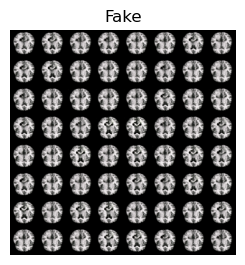

Train Epoch: 66 [1920/5000] D-Loss: 0.462170 G-Loss: 2.577061
Train Epoch: 66 [3968/5000] D-Loss: 0.829438 G-Loss: 2.561436
Train Epoch: 66 [6016/5000] D-Loss: 0.379216 G-Loss: 3.626442
Train Epoch: 67 [1920/5000] D-Loss: 0.566051 G-Loss: 3.835438
Train Epoch: 67 [3968/5000] D-Loss: 0.312500 G-Loss: 4.869793
Train Epoch: 67 [6016/5000] D-Loss: 1.237827 G-Loss: 6.728691
Train Epoch: 68 [1920/5000] D-Loss: 0.760846 G-Loss: 3.553924
Train Epoch: 68 [3968/5000] D-Loss: 0.221489 G-Loss: 4.302754
Train Epoch: 68 [6016/5000] D-Loss: 0.295149 G-Loss: 3.926167
Train Epoch: 69 [1920/5000] D-Loss: 0.303913 G-Loss: 4.079391
Train Epoch: 69 [3968/5000] D-Loss: 0.450124 G-Loss: 4.902692
Train Epoch: 69 [6016/5000] D-Loss: 0.307388 G-Loss: 3.738111
Train Epoch: 70 [1920/5000] D-Loss: 0.499332 G-Loss: 3.788627
Train Epoch: 70 [3968/5000] D-Loss: 1.000288 G-Loss: 3.621817
Train Epoch: 70 [6016/5000] D-Loss: 0.345774 G-Loss: 3.633478


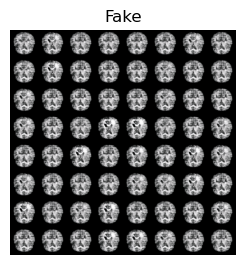

Train Epoch: 71 [1920/5000] D-Loss: 0.456077 G-Loss: 4.180548
Train Epoch: 71 [3968/5000] D-Loss: 0.470955 G-Loss: 2.590944
Train Epoch: 71 [6016/5000] D-Loss: 0.320709 G-Loss: 3.051486
Train Epoch: 72 [1920/5000] D-Loss: 0.323433 G-Loss: 4.303418
Train Epoch: 72 [3968/5000] D-Loss: 0.688678 G-Loss: 5.063155
Train Epoch: 72 [6016/5000] D-Loss: 0.608464 G-Loss: 8.791400
Train Epoch: 73 [1920/5000] D-Loss: 0.307055 G-Loss: 3.718576
Train Epoch: 73 [3968/5000] D-Loss: 0.253538 G-Loss: 4.655527
Train Epoch: 73 [6016/5000] D-Loss: 0.297835 G-Loss: 4.410706
Train Epoch: 74 [1920/5000] D-Loss: 0.599724 G-Loss: 2.549782
Train Epoch: 74 [3968/5000] D-Loss: 0.467650 G-Loss: 4.826925
Train Epoch: 74 [6016/5000] D-Loss: 0.117892 G-Loss: 4.276830
Train Epoch: 75 [1920/5000] D-Loss: 0.882187 G-Loss: 6.009505
Train Epoch: 75 [3968/5000] D-Loss: 0.330788 G-Loss: 4.177440
Train Epoch: 75 [6016/5000] D-Loss: 0.142243 G-Loss: 4.769705


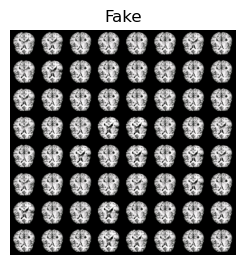

Train Epoch: 76 [1920/5000] D-Loss: 0.930533 G-Loss: 1.496459
Train Epoch: 76 [3968/5000] D-Loss: 0.123270 G-Loss: 4.600114
Train Epoch: 76 [6016/5000] D-Loss: 0.279817 G-Loss: 4.005948
Train Epoch: 77 [1920/5000] D-Loss: 0.494490 G-Loss: 5.825949
Train Epoch: 77 [3968/5000] D-Loss: 1.461688 G-Loss: 7.251351
Train Epoch: 77 [6016/5000] D-Loss: 0.391305 G-Loss: 8.335816
Train Epoch: 78 [1920/5000] D-Loss: 0.310106 G-Loss: 7.101126
Train Epoch: 78 [3968/5000] D-Loss: 0.245831 G-Loss: 3.854228
Train Epoch: 78 [6016/5000] D-Loss: 0.117588 G-Loss: 4.326218
Train Epoch: 79 [1920/5000] D-Loss: 0.353043 G-Loss: 3.377371
Train Epoch: 79 [3968/5000] D-Loss: 0.814906 G-Loss: 3.292036
Train Epoch: 79 [6016/5000] D-Loss: 0.290173 G-Loss: 3.774748
Train Epoch: 80 [1920/5000] D-Loss: 0.193964 G-Loss: 4.107721
Train Epoch: 80 [3968/5000] D-Loss: 0.601599 G-Loss: 4.363950
Train Epoch: 80 [6016/5000] D-Loss: 0.724586 G-Loss: 8.054670


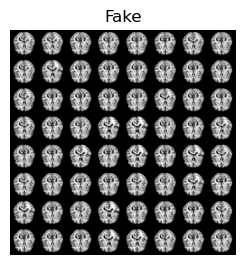

Train Epoch: 81 [1920/5000] D-Loss: 1.834056 G-Loss: 5.708974
Train Epoch: 81 [3968/5000] D-Loss: 0.499039 G-Loss: 2.288345
Train Epoch: 81 [6016/5000] D-Loss: 0.454982 G-Loss: 3.396752
Train Epoch: 82 [1920/5000] D-Loss: 0.518975 G-Loss: 4.194656
Train Epoch: 82 [3968/5000] D-Loss: 0.853817 G-Loss: 2.857837
Train Epoch: 82 [6016/5000] D-Loss: 0.600645 G-Loss: 5.888038
Train Epoch: 83 [1920/5000] D-Loss: 0.600347 G-Loss: 4.196224
Train Epoch: 83 [3968/5000] D-Loss: 0.617052 G-Loss: 2.993189
Train Epoch: 83 [6016/5000] D-Loss: 0.736300 G-Loss: 2.681528
Train Epoch: 84 [1920/5000] D-Loss: 0.373562 G-Loss: 4.070043
Train Epoch: 84 [3968/5000] D-Loss: 0.448438 G-Loss: 4.540978
Train Epoch: 84 [6016/5000] D-Loss: 0.643787 G-Loss: 5.481877
Train Epoch: 85 [1920/5000] D-Loss: 0.076039 G-Loss: 4.833040
Train Epoch: 85 [3968/5000] D-Loss: 0.595265 G-Loss: 3.259089
Train Epoch: 85 [6016/5000] D-Loss: 0.322511 G-Loss: 3.400573


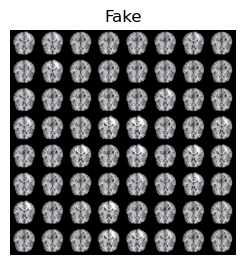

Train Epoch: 86 [1920/5000] D-Loss: 0.617445 G-Loss: 3.555153
Train Epoch: 86 [3968/5000] D-Loss: 2.096704 G-Loss: 2.017271
Train Epoch: 86 [6016/5000] D-Loss: 0.368166 G-Loss: 3.262436
Train Epoch: 87 [1920/5000] D-Loss: 0.580030 G-Loss: 4.141155
Train Epoch: 87 [3968/5000] D-Loss: 0.393258 G-Loss: 4.528088
Train Epoch: 87 [6016/5000] D-Loss: 0.603971 G-Loss: 4.511047
Train Epoch: 88 [1920/5000] D-Loss: 0.337258 G-Loss: 4.630699
Train Epoch: 88 [3968/5000] D-Loss: 0.487438 G-Loss: 3.954466
Train Epoch: 88 [6016/5000] D-Loss: 0.263009 G-Loss: 2.974656
Train Epoch: 89 [1920/5000] D-Loss: 0.315792 G-Loss: 4.855607
Train Epoch: 89 [3968/5000] D-Loss: 0.047506 G-Loss: 6.404248
Train Epoch: 89 [6016/5000] D-Loss: 0.093613 G-Loss: 6.918266
Train Epoch: 90 [1920/5000] D-Loss: 1.140128 G-Loss: 4.861363
Train Epoch: 90 [3968/5000] D-Loss: 0.362410 G-Loss: 4.246180
Train Epoch: 90 [6016/5000] D-Loss: 0.393055 G-Loss: 3.921970


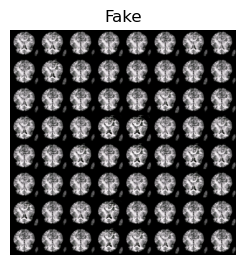

Train Epoch: 91 [1920/5000] D-Loss: 0.211894 G-Loss: 4.002560
Train Epoch: 91 [3968/5000] D-Loss: 0.675562 G-Loss: 2.097031
Train Epoch: 91 [6016/5000] D-Loss: 0.523734 G-Loss: 3.677448


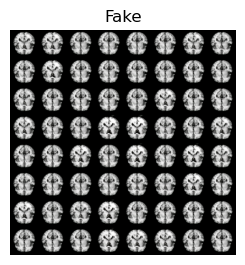

Train Epoch: 92 [1920/5000] D-Loss: 0.729768 G-Loss: 2.195317
Train Epoch: 92 [3968/5000] D-Loss: 0.387683 G-Loss: 3.353424
Train Epoch: 92 [6016/5000] D-Loss: 0.851723 G-Loss: 3.480939


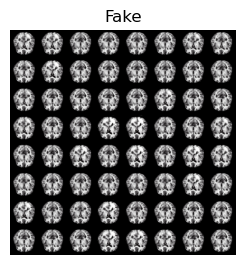

Train Epoch: 93 [1920/5000] D-Loss: 0.400232 G-Loss: 2.964131
Train Epoch: 93 [3968/5000] D-Loss: 0.432827 G-Loss: 5.224907
Train Epoch: 93 [6016/5000] D-Loss: 0.356236 G-Loss: 3.687192


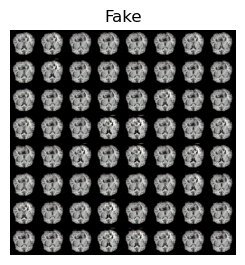

Train Epoch: 94 [1920/5000] D-Loss: 1.034054 G-Loss: 3.571905
Train Epoch: 94 [3968/5000] D-Loss: 0.972740 G-Loss: 5.441704
Train Epoch: 94 [6016/5000] D-Loss: 0.473469 G-Loss: 2.993345


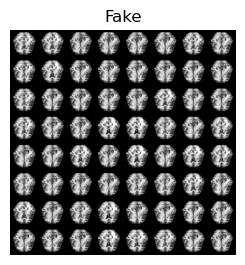

Train Epoch: 95 [1920/5000] D-Loss: 0.693970 G-Loss: 2.932011
Train Epoch: 95 [3968/5000] D-Loss: 0.781657 G-Loss: 2.631963
Train Epoch: 95 [6016/5000] D-Loss: 0.265479 G-Loss: 3.621550


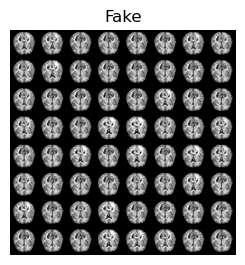

Train Epoch: 96 [1920/5000] D-Loss: 0.386407 G-Loss: 4.298824
Train Epoch: 96 [3968/5000] D-Loss: 0.581149 G-Loss: 4.737599
Train Epoch: 96 [6016/5000] D-Loss: 0.389731 G-Loss: 5.231346


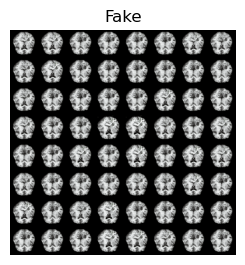

Train Epoch: 97 [1920/5000] D-Loss: 0.670395 G-Loss: 3.106375
Train Epoch: 97 [3968/5000] D-Loss: 0.156082 G-Loss: 3.479836
Train Epoch: 97 [6016/5000] D-Loss: 0.322117 G-Loss: 3.619271


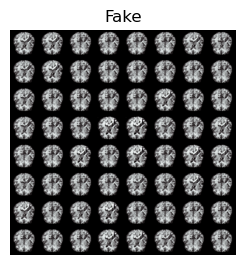

Train Epoch: 98 [1920/5000] D-Loss: 0.301556 G-Loss: 4.272038
Train Epoch: 98 [3968/5000] D-Loss: 0.200067 G-Loss: 3.007439
Train Epoch: 98 [6016/5000] D-Loss: 0.292570 G-Loss: 5.499386


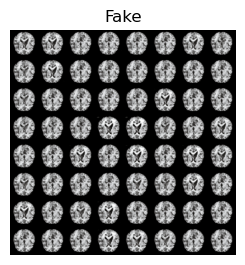

Train Epoch: 99 [1920/5000] D-Loss: 0.138774 G-Loss: 4.464682
Train Epoch: 99 [3968/5000] D-Loss: 0.405471 G-Loss: 4.986885
Train Epoch: 99 [6016/5000] D-Loss: 0.425403 G-Loss: 5.056683


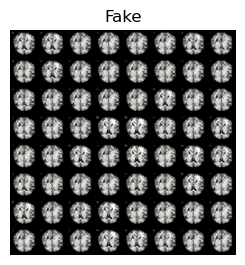

Train and predict complete!


In [7]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

summaryWriter = SummaryWriter("logs/GAN_recorded_4")

img_list = []
all_d_loss = []
all_g_loss = []


for epoch in range(100):
    errAll = 0
    errG = 0
    for i, data in enumerate(dataloader, 0):
        # Train with real batch
        optimizer_d.zero_grad()
        inputs_gpu = data[0].to(device)
        label = torch.full((BATCH_SIZE,), 1, dtype=torch.float, device=device)
        outputs_gpu = dnet_gpu(inputs_gpu).view(-1)
        d_loss_real = loss_func(outputs_gpu, label)
        d_loss_real.backward()
        D_x = outputs_gpu.mean().item()
        
        # Train with fake batch
        rand_noise = torch.randn(BATCH_SIZE, RAND_DIM, 1, 1, device=device)
        fake_images = gnet_gpu(rand_noise)
        label.fill_(0)
        outputs_fake = dnet_gpu(fake_images.detach()).view(-1)
        fake_loss = loss_func(outputs_fake, label)
        fake_loss.backward()
        D_G_z1 = outputs_fake.mean().item()
        errAll = d_loss_real + fake_loss
        optimizer_d.step()

        # Update G
        optimizer_g.zero_grad()
        label.fill_(1)
        outputs_g = dnet_gpu(fake_images).view(-1)
        errG = loss_func(outputs_g, label)
        errG.backward()
        # D_G_z2 = outputs_g.mean().item()
        optimizer_g.step()
        
        if i % 16 == 15:
            print('Train Epoch: %d [%d/5000] D-Loss: %.6f G-Loss: %.6f'  %(epoch, i*128,errAll.item(), errG.item()))
    summaryWriter.add_scalar("d_loss", errAll, epoch)
    summaryWriter.add_scalar("g_loss", errG, epoch)
    all_d_loss = np.append(all_d_loss,errAll.item())
    # print(all_d_loss)
    all_g_loss = np.append(all_g_loss,errG.item())
    # print(all_g_loss)
    
    if (epoch % 5 == 0 or epoch > 90):
        with torch.no_grad():
            fake = gnet_gpu(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()

print('Train and predict complete!')    

torch.Size([1042, 1042, 3])


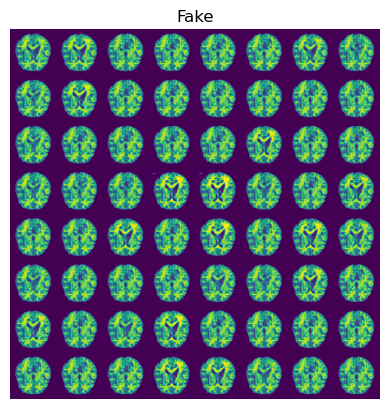

In [63]:
plt.axis("off")
plt.title("Fake")
pics = np.transpose(img_list[26],(1,2,0))
plt.imshow(pics[:,:,-1])
print(pics.size())
plt.show()

torch.Size([1042, 1042, 3])


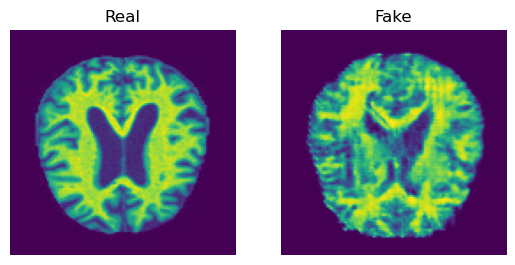

In [50]:
from PIL import Image
fig=Image.open("./archive/Dataset/Mild_Demented/mild.jpg")
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real")
plt.imshow(fig)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake")
pics = np.transpose(img_list[26],(1,2,0))
plt.imshow(pics[0:128,0:128,-1])
print(pics.size())
plt.show()

# CNN

In [41]:
import numpy as np
import sklearn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Any Reason for this?
])

data=ImageFolder("./archive/Dataset/", transform=data_transform)

n=len(data)
n_test=int(0.2*n)   # 20% for test
train_data,test_data=random_split(data,[n-n_test,n_test],torch.Generator().manual_seed(42))

trainloader=DataLoader(train_data,batch_size=128,drop_last=False,shuffle=True)
testloader=DataLoader(test_data,batch_size=128,drop_last=False,shuffle=False)

import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Set for convolution operation
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, padding=1), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.dp = torch.nn.Dropout(p=0.5)

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*8*8, 32),
            torch.nn.ReLU()
        )
        self.fc2 = torch.nn.Linear(32, 4)
        
    def forward(self, x):
        # Three-layer convolutional network (Conv -> ReLU -> MaxPool)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dp(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x) # Fully connected layer -> ReLU
        x = self.fc2(x) 
        out = F.log_softmax(x, dim=1) # Softmax probability
        return out

net_cpu = ConvNet()
net_gpu = net_cpu.cuda()

from torch import optim
from torch.utils.tensorboard import SummaryWriter

summaryWriter = SummaryWriter("logs/lyf_cnn_gan")

optimizer = optim.Adam(
    net_gpu.parameters(),
    lr = 0.001,
    betas = (0.9, 0.999),
    eps = 1e-08,
    weight_decay = 0,
    amsgrad = False
)

loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(50):
    running_loss_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs_cpu, targets_cpu = data
        inputs_gpu = inputs_cpu.cuda()
        targets_gpu = targets_cpu.cuda()
        optimizer.zero_grad()
        outputs_gpu = net_gpu.train()(inputs_gpu)
        loss = loss_func(outputs_gpu, targets_gpu)
        running_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        if i % 8 == 7:
            print('Train Epoch: %d [%d/5000] Loss: %.6f' %(epoch, i*64, loss.item()))
    running_loss_train /= len(trainloader)
    print(running_loss_train)
    summaryWriter.add_scalar("loss", running_loss_train, epoch)

    # Step 4 Predict
    correct = 0
    total = 0
    running_loss = 0
    for data in testloader:
        images_cpu, targets_cpu = data
        images_gpu = images_cpu.cuda()
        targets_gpu = targets_cpu.cuda()
        outputs_gpu = net_gpu.eval()(images_gpu)
        _, predicted = torch.max(outputs_gpu, 1)
        loss = loss_func(outputs_gpu, targets_gpu)
        total += targets_gpu.size(0)
        running_loss += loss.item()
        correct += (predicted == targets_gpu).sum().item()
    
    running_loss = running_loss / 10000

    print('Test set: Average loss: %.4f, Accuracy: %d/10000 (%d%%)' %(running_loss, correct, correct*100/total))
    summaryWriter.add_scalar("accuracy", correct/total, epoch)

print('Train and predict complete!')    

Train Epoch: 0 [448/5000] Loss: 1.184302
Train Epoch: 0 [960/5000] Loss: 0.984301
Train Epoch: 0 [1472/5000] Loss: 1.056733
Train Epoch: 0 [1984/5000] Loss: 0.995560
Train Epoch: 0 [2496/5000] Loss: 1.166978
1.059310682117939
Test set: Average loss: 0.0010, Accuracy: 660/10000 (51%)
Train Epoch: 1 [448/5000] Loss: 0.945711
Train Epoch: 1 [960/5000] Loss: 1.042292
Train Epoch: 1 [1472/5000] Loss: 0.899025
Train Epoch: 1 [1984/5000] Loss: 1.041971
Train Epoch: 1 [2496/5000] Loss: 0.946131
0.9780660063028336
Test set: Average loss: 0.0010, Accuracy: 669/10000 (52%)
Train Epoch: 2 [448/5000] Loss: 0.912323
Train Epoch: 2 [960/5000] Loss: 0.926343
Train Epoch: 2 [1472/5000] Loss: 0.899762
Train Epoch: 2 [1984/5000] Loss: 0.842545
Train Epoch: 2 [2496/5000] Loss: 0.981674
0.9380198255181312
Test set: Average loss: 0.0009, Accuracy: 691/10000 (53%)
Train Epoch: 3 [448/5000] Loss: 0.864307
Train Epoch: 3 [960/5000] Loss: 0.909338
Train Epoch: 3 [1472/5000] Loss: 0.874002
Train Epoch: 3 [1984/5

torch.Size([512, 512, 3])


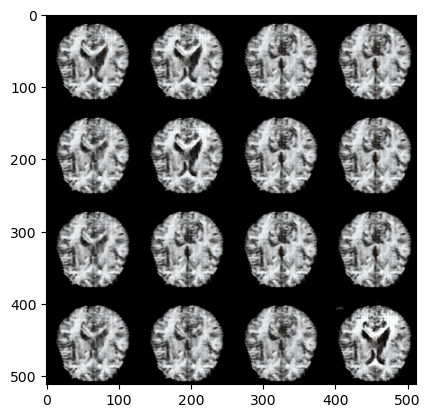

In [61]:
pics = np.transpose(img_list[26],(1,2,0))
pic1 = pics[:512,:512,:3]
plt.imshow(pic1)
print(pic1.shape)

In [96]:
# save figures
for i in range(8):
    for j in range(8):
        pic1=np.transpose(img_list[26],(1,2,0))
        pic1=pic1[128*i:128*i+128,128*j:128*j+128,:3]
        plt.imsave(f'./gan_pic/0/{8*i+j}.png',pic1.numpy())

        pic2=np.transpose(img_list[27],(1,2,0))
        pic2=pic2[128*i:128*i+128,128*j:128*j+128,:3]
        plt.imsave(f'./gan_pic/0/{8*i+j+64}.png',pic2.numpy())

In [97]:
gan_data=ImageFolder("./gan_pic/", transform=data_transform)
gan_testloader=DataLoader(gan_data,batch_size=128,drop_last=False,shuffle=False)

types = ['Mild', 'Moderate', 'Non','Very Mild']
predicted = []
result = []
for data in gan_testloader:
    images_cpu, targets_cpu = data
    images_gpu = images_cpu.cuda()
    targets_gpu = targets_cpu.cuda()
    outputs_gpu = net_gpu.eval()(images_gpu)
    _, predicted = torch.max(outputs_gpu, 1)
    predicted=predicted.cpu().numpy()
    print(predicted)
    result = [types[i] for i in predicted]
    print(result)

[2 2 2 0 2 3 3 3 2 2 2 0 2 2 2 2 0 2 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 3 2 2
 2 3 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 0 2 2 3 2 2 3 2]
['Non', 'Non', 'Non', 'Mild', 'Non', 'Very Mild', 'Very Mild', 'Very Mild', 'Non', 'Non', 'Non', 'Mild', 'Non', 'Non', 'Non', 'Non', 'Mild', 'Non', 'Very Mild', 'Mild', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Very Mild', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Very Mild', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Very Mild', 'Non', 'Non', 'Non', 'Very Mild', 'Non', 'Non', 'Non', 'Non', 'Very Mild', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', 'Non', '

In [98]:
print(np.where(predicted==0))
print(np.where(predicted==1))
print(np.where(predicted==2))
print(np.where(predicted==3))

(array([  3,  11,  16,  19, 120], dtype=int64),)
(array([], dtype=int64),)
(array([  0,   1,   2,   4,   8,   9,  10,  12,  13,  14,  15,  17,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  60,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  72,  73,  74,  76,
        77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 121, 122, 124, 125, 127], dtype=int64),)
(array([  5,   6,   7,  18,  53,  61,  71,  75,  80, 119, 123, 126],
      dtype=int64),)


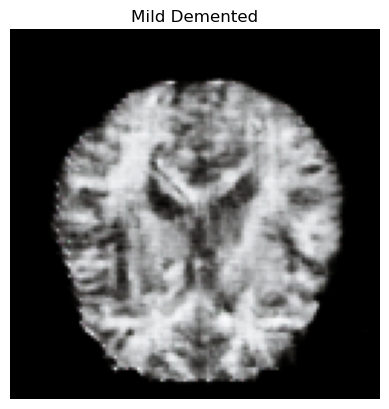

In [106]:
fig=Image.open("./gan_pic/0/16.png")
plt.axis("off")
plt.title("Mild Demented")
plt.imshow(fig)

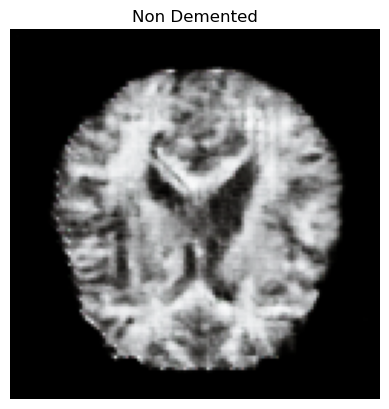

In [100]:
fig=Image.open("./gan_pic/0/0.png")
plt.axis("off")
plt.title("Non Demented")
plt.imshow(fig)

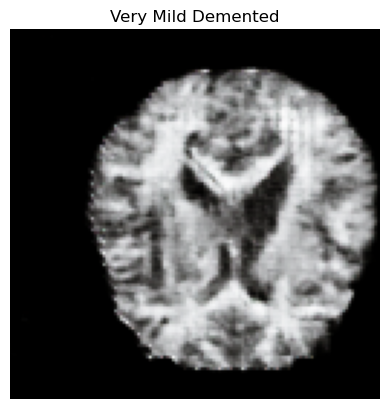

In [109]:
fig=Image.open("./gan_pic/0/6.png")
plt.axis("off")
plt.title("Very Mild Demented")
plt.imshow(fig)